# Assignment 4

In this assignment I will be modelling the heat dissipation in a 2-dimensional square plate. We are using equation 1 to model the temperature evolution.

$$ \frac{\partial u}{\partial t}
   = \left( \frac{\partial^2 u}{\partial x^2}
      + \frac{\partial^2 u}{\partial y^2}
       \right)\tag{1} $$     
       
u is the temperature of the plate at a certain time.

The boundary conditions I have introduced are:

* The bottom row of the plate is initally and always at $u(x, 0) = 5$

* The top row and right most and left most columns of the plate are kept at a constant temperature of $u(x, 0) = 0$

## Finite Difference Scheme

In order to discretize $ u_t = \Delta u$, we use the finite diffence method. This method approximates the time derivative $\frac{du}{dt}$ in two possible ways:


* The forward difference: 

$$
\frac{du}{dt}\approx \frac{u(x + h) - u(x)}{h}.
$$

* The backward difference: 

$$
\frac{du}{dt}\approx \frac{u(x) - u(x - h)}{h}.
$$

Both these methods are used to approximate equation 1.

# Forward Euler Method (Explicit)

The forward Euler method uses the forward difference above. The time and spatial domains need to be discretised meaning they can be written as:

$$x_i = i\Delta{x}$$

$$t_k = k\Delta{t}$$
 
Since we are considering a square plate, the discretization in the  𝑦  direction is the same as the  𝑥  direction which leads to the LHS of (1) being:

$$
\frac{u_{i,j}^{k+1} - u_{i,j}^{k}}{\Delta t}\tag{2}
$$

The RHS of (1) is:

$$
\Delta u_{i, j}\approx -\frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{h^2}\tag{3}
$$

which was looked at thoroughly in previous assignments.

We then rearrenge for $u_{i,j}^{k+1}$ and get:

$$u_{i,j}^{k+1} = u_{i, j}^{k}-\Delta{t}\frac{4u_{i, j}^{k} - u_{i - 1, j}^{k} - u_{i + 1, j}^{k} - u_{i, j - 1}^{k} - u_{i, j+ 1}^{k}}{h^2}\tag{4}$$

$\frac{\Delta{t}}{h^2}$ is the Courant Number which needs to be smaller than 0.5 for the forward method to be stable.

The code uses Numba Just-In-Time Compiler and prange parallelisation to efficiently loop over each interior position on the grid.

In [1]:
# Imports all the needed built in libraries
%matplotlib notebook
import numpy as np
from numba import njit, prange
import time
import matplotlib.pyplot as plt

# Define function for plot
def plot(u):
    plt.figure(figsize=(8, 6))
    plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Reds')
    plt.colorbar()
    plt.show()

In [2]:
# Define timer 
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [3]:
@njit(parallel=True)
def diffusion(n, m, u):
    """
    This function implements the Central Differences 5-point stencil and Forward Euler Method
    time stepping in one expression.
    Input:
    n = dimensions of matrix
    m = number of time steps in matrix
    u = the initial matrix at t = 0
    output:
    v = matrix after the 5-point stencil has been applied 
    """
    v = np.copy(u)
    for i in prange(1, n - 1):
        for j in range(1, n - 1):
            v[i, j] = u[i, j] - (4 * u[i, j] - u[i - 1, j] - u[i + 1, j] - u[i, j - 1] - u[i, j + 1]) * \
                        (n - 1) * (n - 1) / (4 * (m - 1))  
    return v

N: 101
M: 40001
C: 0.0625
T: 0.4240000000000000
Total Time: 4.5579633712768555


<IPython.core.display.Javascript object>


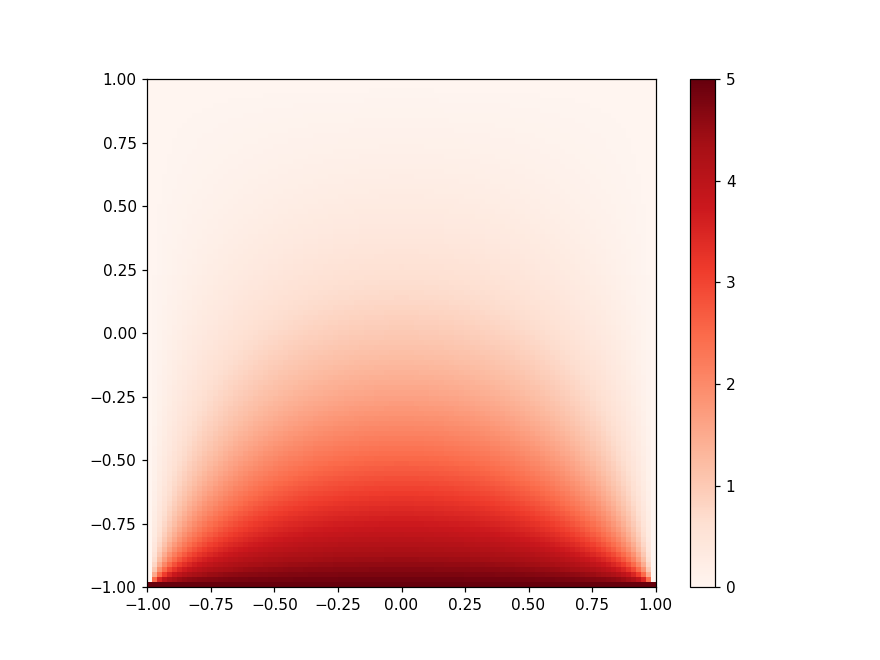

In [4]:
# defining n and m 
N = 101
M = 40001

print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

# Input array with boundary conditions
u = np.zeros((N, N), dtype=np.float64)
u[0, :] = 5.0

# The number of iterations of diffusion
k = 0

with Timer() as t:
    
    # Temperature at centre of plate.
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0: 
        u = diffusion(N, M, u)
        k = k + 1
    
print("T: {:.16f}".format(k / (M - 1)))
print("Total Time: {0}".format(t.interval))

plot(u)

As can be seen from above when N is 101 and M is 40,001 I was able to get T to 3.d.p. During testing the best result in the most reasonable time I was able to obtain was at 4,000,001:

N: 201 \
M: 4,000,001 \
C: 0.0025 \
T: 0.4240115000000000 \
Total Time: 84.15924048423767

As can be seen from above 6.d.p was the best I could achieve for the forward method.

# Backwards Euler Method (Implicit)

The backward Euler method uses the backward difference above. The time and spatial domains are discretised in the same way as in the forward Euler.

The discretization in the  𝑦  direction is still the same as the  𝑥  direction but instead leads to in the LHS:

$$
\frac{u_{i,j}^{k} - u_{i,j}^{k-1}}{\Delta t}\tag{5}
$$

The RHS is still represented by (3).

We then rearrange for $u_{i,j}^{k-1}$ and get:

$$u_{i,j}^{k-1} = u_{i, j}^{k}+\Delta{t}\frac{4u_{i, j}^{k} - u_{i - 1, j}^{k} - u_{i + 1, j}^{k} - u_{i, j - 1}^{k} - u_{i, j+ 1}^{k}}{h^2}\tag{6}$$

The biggest advantage of the backwards method is that it is unconditionally stable so the value of the Courant Number is insignificant.

The matrix equation is used:

$$AU = f\tag{7}$$

When A (Matrix of coefficent) is formed, U can be found using a solver resulting in a vector representing $u_{i,j}^{k}$. A new matrix $u_{i,j}$ is found for each k step which will update f.

The function below creats a sparse matrix for A and forms f. The sparse matrix uses the coefficients for (6).

In [5]:
from scipy.sparse import coo_matrix

# Function for sparse matrix
def discretise_poisson(N, M):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.zeros(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[(0) * N + i] = 5
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 1 + (4 * (N - 1)**2)/(4*(M - 1))
                data[count + 1 : count + 5] = (-(N - 1)**2)/(4*(M - 1))
                # f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [6]:
# Define N and M
Nbck = 101
Mbck = 10001

# Printing A and f for check
A,f = discretise_poisson(Nbck, Mbck)
print(A)
print(f.reshape(Nbck,Nbck))

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (10176, 10176)	1.0
  (10177, 10177)	1.0
  (10178, 10178)	1.0
  (10179, 10179)	1.0
  (10180, 10180)	1.0
  (10181, 10181)	1.0
  (10182, 10182)	1.0
  (10183, 10183)	1.0
  (10184, 10184)	1.0
  (10185, 10185)	1.0
  (10186, 10186)	1.0
  (10187, 10187)	1.0
  (10188, 10188)	1.0
  (10189, 10189)	1.0
  (10190, 10190)	1.0
  (10191, 10191)	1.0
  (10192, 10192)	1.0
  (10193, 10193)	1.0
  (10194, 10194)	1.0
  (10195, 10195)	1.0
  (10196, 10196)	1.0
  (10197, 10197)	1.0
  (10198, 10198)	1.0
  (10199, 10199)	1.0
  (10200, 10200)	1.0
[[5. 5. 5. ... 5. 5. 5.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

N: 101
M: 10001
C: 0.25
T: 0.4245000000000000
Total Time: 107.15792489051819


<IPython.core.display.Javascript object>


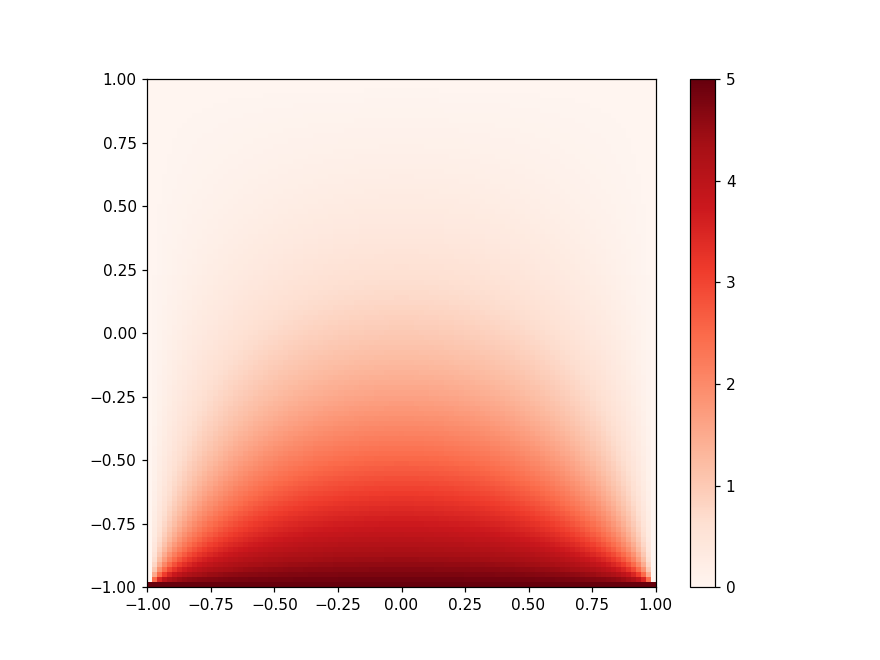

In [7]:
from scipy.sparse.linalg import spsolve

print("N: {}".format(Nbck))
print("M: {}".format(Mbck))
print("C: {}".format(((Nbck - 1) * (Nbck - 1)) / (4 * (Mbck - 1))))

u1 = spsolve(A,f)

# The number of iterations of diffusion (one has been done)
k = 1

with Timer() as t:
    while u1[((Nbck)**2//2)-1] < 1.0: 
        f = u1
        u1 = spsolve(A,f)
        k = k+1
            
u1 = u1.reshape(Nbck,Nbck)      
print("T: {:.16f}".format(k / (Mbck - 1)))
print("Total Time: {0}".format(t.interval))

plot(u1)

As can be seen from above when N is 101 and M is 10,001 I was able to get T to 3.d.p which took 106 seconds (which I assume is fine as its less than 2 minutes). These were the biggest values I tested with as I would have to wait for very long times for bigger values.

# Comparison

The results above show that the forward method is better as it takes about 100 times less to obtain the same level of accuracy as the backwards method. Also, it can be done for much higher N more easily as the backwards method solver will take ridiculously long for big N due to the sheer numbers of iterations.

<IPython.core.display.Javascript object>


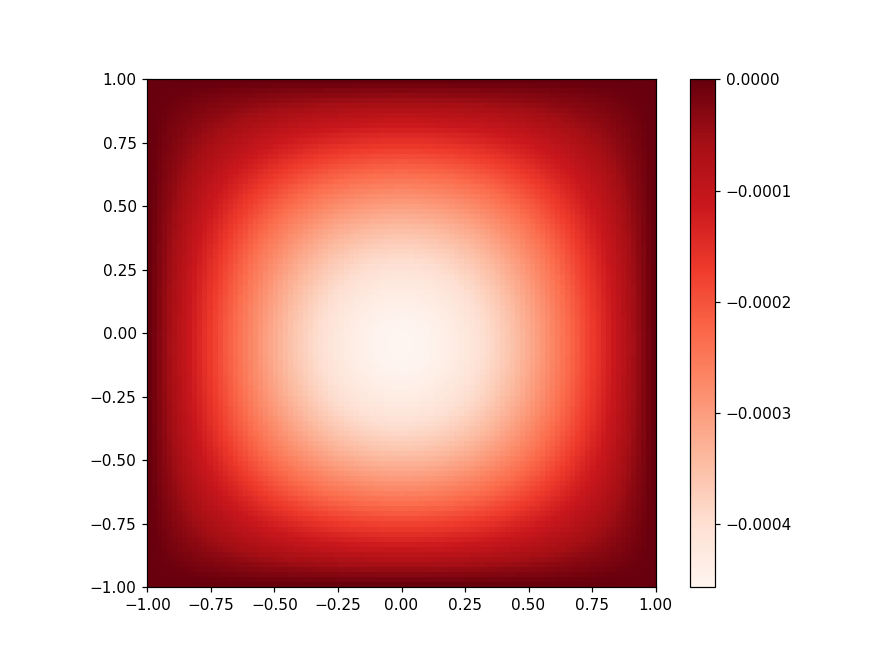

In [8]:
r = u-u1
plot(r)

As the biggest difference between the 2 output matrices for forward and backwards is about 0.0004 the uncertainty between the two is very small.